<a href="https://colab.research.google.com/github/Pablo-Valde/Segmentacion/blob/main/laboratorio_segmentacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align='center'>Laboratorio de Segmentación</h1>

<h2>1. Importación de Librerías</h2>

Para simplificar el ejercicio, primero importaremos las librerías, sin necesidad de levantar un ambiente virtual e instalarlas en éste, gracias a las virtudes de Google Colaboratory como editor. Otra de las ventajas de  este intérprete de Python, es que funciona con el formato de celdas de los *Jupyter Notebooks*. Esto permite trabajar bajo el paradigma de lo que se denomina *Literate Programming*, pudiéndose hacer un claro énfasis en la estructura lógica del programa.

Para ejecutar la celda a continuación, bastará que usted la seleccione apretando sobre ella con el cursor, y luego apriete <code>shift+enter</code>




In [1]:
# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Operational Libraries
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h2>2. Lectura de la Tabla de Datos</h2>

Para ejercitar, utilizaremos una tabla de datos (en adelante <i>dataset</i>) recolectados a partir de la encuesta de segmentación realizada a la salida de los locales Bimarc Food Market. Los datos no han sido procesados, por lo que hay ciertos campos que se transformarán y otros tantos que enriqueceremos en el proceso de segmentación.

Es importante notar que hay una columna numérica de identificación de los sujetos, denominada "Identificador". No se confunda, esta variable es arbitraria para todos los efectos prácticos, y no debe ser considerada para el análisis, salvo que sea considerada como llave relacional. Si usted no se encuentra familiarizado con el lenguaje y las librerías, Pandas incluye siempre un índice que comúnmente es también numérico. No confunda el índice con la columna de identificación.

In [2]:
# Importing the prospects dataset using pandas from a local CSV file
file_name = 'base-cantidades-ix-epf-(formato-csv).csv'  # Replace with the actual file name
dataset = pd.read_csv(file_name, delimiter=';', on_bad_lines='skip')

file_path_excel = 'diccionario-de-variables-ix-epf(1).xlsx'
xls = pd.ExcelFile(file_path_excel)

# Display of last 5 rows
dataset.tail(5)

macrozona  folio_v   folio  n_linea                 fe  \
958193          4     9998  9998-1      1.0  158,4609379966400   
958194          4     9998  9998-1      1.0  158,4609379966400   
958195          4     9998  9998-1      1.0  158,4609379966400   
958196          4     9999  9999-1    -77.0  130,6225757230620   
958197          4     9999  9999-1    -77.0  130,6225757230620   

        estrato_muestreo  var_unit   id_gasto              cantidad  \
958193                38      2972  9998-1-15  1,10714285714286e+03   
958194                38      2972   9998-1-7  1,10714285714286e+03   
958195                38      2972   9998-1-8  1,10714285714286e+03   
958196                11      2869   9999-1-1  1,00000000000000e+00   
958197                11      2869   9999-1-2  1,00000000000000e+00   

       unidad_medida  ...     d    g    c   sc     p                 gasto  \
958193            ML  ...   1.0  2.0  5.0  1.0   1.0  1,43928571428571e+03   
958194            ML  ...   1.0  2.0  9.0  1.0   2.0  3,29928571428571e+03   
958195            ML  ...   1.0  2.0  9.0  1.0   2.0  3,29928571428571e+03   
958196        COMPRA  ...   2.0  5.0  1.0  1.0   1.0  2,48000000000000e+02   
958197           -77  ...  11.0  1.0  1.0  1.0  13.0  6,32653061224490e+03   

                        glosa_establecimiento cod_establecimiento  \
958193                          SUPERMERCADOS                   1   
958194                          SUPERMERCADOS                   1   
958195                          SUPERMERCADOS                   1   
958196  FERIA ARTESANAL - FERIA DE LAS PULGAS                  20   
958197                   RESTAURANTES Y BARES                   4   

       cantidad_inicial  unidad_medida_inicial  
958193          500,000                     CC  
958194          500,000                     CC  
958195          500,000                     CC  
958196          -77,000                    -77  
958197          -77,000                    -77  

[5 rows x 22 columns]

In [3]:
# Mostrar información general del dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958198 entries, 0 to 958197
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   macrozona              958198 non-null  int64  
 1   folio_v                958198 non-null  int64  
 2   folio                  958198 non-null  object 
 3   n_linea                958119 non-null  float64
 4   fe                     958198 non-null  object 
 5   estrato_muestreo       958198 non-null  int64  
 6   var_unit               958198 non-null  int64  
 7   id_gasto               958198 non-null  object 
 8   cantidad               953792 non-null  object 
 9   unidad_medida          958198 non-null  object 
 10  glosa_ccif             958117 non-null  object 
 11  ccif                   958198 non-null  object 
 12  d                      958117 non-null  float64
 13  g                      958117 non-null  float64
 14  c                      958117 non-nu

<h2>3. Transformación de los Datos</h2>

A continuación procederemos a transformar los datos, creando un dataset numérico a partir del que descargamos. Si bien es más costoso en memoria el uso de réplicas completas de los datasets utilizados, esta práctica es conveniente cuando se trabaja con Jupyter Notebooks que podrían ser ejecutados en desorden o múltiples veces.

In [4]:
# Copying our dataset to avoid future issues
dataset_numerico = dataset.copy(deep=True)

Tambien nos interesa filtrar de antemano la base para ciertos aspectos que son de nuestro interes, por ejemplo filtrar para el sector de gran santiago

In [5]:
filtro_geografico = dataset_numerico[dataset_numerico['macrozona'] == 'Gran Santiago']
establecimientos_incluidos = ['SUPERMERCADOS', 'ALMACÉN TRADICIONAL', 'TIENDA ESPECIALIZADA']
filtro_geografico = dataset_numerico[dataset_numerico['glosa_establecimiento'].isin(establecimientos_incluidos)] 
filtered_dataset = filtro_geografico.applymap(lambda x: 0 if x == -77 or x == -77.0 else x)
filtered_dataset = filtered_dataset.applymap(lambda x: 0 if x == -88 or x == -88.0 else x)
filtered_dataset = filtered_dataset.applymap(lambda x: 0 if x == -99 or x == -99.0 else x)
filtered_dataset.tail(5)

/tmp/ipykernel_907/537820176.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_dataset = filtro_geografico.applymap(lambda x: 0 if x == -77 or x == -77.0 else x)
/tmp/ipykernel_907/537820176.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_dataset = filtered_dataset.applymap(lambda x: 0 if x == -88 or x == -88.0 else x)
/tmp/ipykernel_907/537820176.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_dataset = filtered_dataset.applymap(lambda x: 0 if x == -99 or x == -99.0 else x)


macrozona  folio_v   folio  n_linea                 fe  \
958191          4     9998  9998-1      1.0  158,4609379966400   
958192          4     9998  9998-1      1.0  158,4609379966400   
958193          4     9998  9998-1      1.0  158,4609379966400   
958194          4     9998  9998-1      1.0  158,4609379966400   
958195          4     9998  9998-1      1.0  158,4609379966400   

        estrato_muestreo  var_unit   id_gasto              cantidad  \
958191                38      2972  9998-1-34  3,76428571428571e+02   
958192                38      2972  9998-1-35  7,93883036253761e+02   
958193                38      2972  9998-1-15  1,10714285714286e+03   
958194                38      2972   9998-1-7  1,10714285714286e+03   
958195                38      2972   9998-1-8  1,10714285714286e+03   

       unidad_medida  ...    d    g    c   sc    p                 gasto  \
958191            GR  ...  1.0  2.0  2.0  1.0  1.0  6,70928571428571e+03   
958192            GR  ...  1.0  2.0  3.0  1.0  2.0  3,85285714285714e+03   
958193            ML  ...  1.0  2.0  5.0  1.0  1.0  1,43928571428571e+03   
958194            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   
958195            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   

        glosa_establecimiento cod_establecimiento cantidad_inicial  \
958191          SUPERMERCADOS                   1          170,000   
958192          SUPERMERCADOS                   1            1,000   
958193          SUPERMERCADOS                   1          500,000   
958194          SUPERMERCADOS                   1          500,000   
958195          SUPERMERCADOS                   1          500,000   

        unidad_medida_inicial  
958191                     GR  
958192                     KG  
958193                     CC  
958194                     CC  
958195                     CC  

[5 rows x 22 columns]

Recordemos que los datos recolectados en una encuesta pueden ser de cuatro tipos principalmente:

- Nominal: nombres (identificación y clasificación)
- Ordinal: orden (jerarquización, posición relativa)
- Intervalo: cuantificación (cero arbitrario)
- Escala: cuantificación (cero absoluto)

Es importante que usted identifique el tipo de cada variable, para que así le sea más sencillo transformar los datos en información valiosa para su posterior análisis. Para efectos de este ejemplo, dividiremos la transformación de los datos por tipo para mayor claridad, transformando aquellas variables de tipo texto en numéricas según corresponda.

<h3>3.1. Valores Nominales</h3>

Las variables nominales son las siguientes en este caso: CCIF IX EPF(ccif), Glosa teórica CCIF IX EPF (glosa_ccif)(Corresponde al producto), Glosa teórica de los establecimientos(glosa_establecimiento), Cantidad o número de bienes o servicios adquiridos reportada(cantidad_inicial) y Unidad de medida de los bienes o servicios adquiridos reportada(unidad_medida_inicial). A continuación, haremos las transformaciones necesarias para este tipo de variables.

In [6]:
label_encoder = LabelEncoder()

In [7]:
# Identificador doesn't require further transformations

# Mapeo de la variable 'ccif'
#filtered_dataset['ccif_encoded'] = label_encoder.fit_transform(filtered_dataset['ccif'])

# Mapeo de la variable 'glosa_ccif'
#filtered_dataset['glosa_ccif_encoded'] = label_encoder.fit_transform(filtered_dataset['glosa_ccif'])

# Mapeo de la variable 'glosa_establecimiento'
#filtered_dataset['glosa_establecimiento_encoded'] = label_encoder.fit_transform(filtered_dataset['glosa_establecimiento'])

# Mapeo de la variable 'unidad_medida_inicial'
#filtered_dataset['unidad_medida_inicial_encoded'] = label_encoder.fit_transform(filtered_dataset['unidad_medida_inicial'])


# As well as Nacionalidad, Comuna doesn't have any order yet, so we'll do the same
#mapper_city = {city: i for i, city in enumerate(dataset_numerico['Comuna'].unique())}
#dataset_numerico['Comuna'] = dataset_numerico['Comuna'].replace(mapper_city)

<h3>3.2. Variables Ordinales</h3>

Las variables ordinales en este caso son: División CCIF(d), Grupo CCIF(g), Clase CCIF(c), Subclase CCIF(sc), Producto CCIF(p) y Código interno de establecimiento para la clasificación de puntos de compra(cod_establecimiento).

In [11]:
# The column Nivel Educacional is ordered by the analyst from lower to higher
mapper_productos = {'S': 0, 'ND': 1,
                    'SD': 2, 'D': 3}

dataset_numerico['c'] = dataset_numerico['c'].replace(mapper_productos)

# Mapeo de la variable 'd' (División CCIF)
#filtered_dataset['d_encoded'] = label_encoder.fit_transform(filtered_dataset['d'])

# Mapeo de la variable 'g' (Grupo CCIF)
#filtered_dataset['g_encoded'] = label_encoder.fit_transform(filtered_dataset['g'])

# La variable 'c' ya fue mapeada anteriormente

# Mapeo de la variable 'sc' (Subclase CCIF)
#filtered_dataset['sc_encoded'] = label_encoder.fit_transform(filtered_dataset['sc'])

# Mapeo de la variable 'p' (Producto CCIF)
#filtered_dataset['p_encoded'] = label_encoder.fit_transform(filtered_dataset['p'])

# Mapeo de la variable 'cod_establecimiento' (Código interno de establecimiento)
#filtered_dataset['cod_establecimiento_encoded'] = label_encoder.fit_transform(filtered_dataset['cod_establecimiento'])


In [12]:
filtered_dataset.tail(5)

macrozona  folio_v   folio  n_linea                 fe  \
958191          4     9998  9998-1      1.0  158,4609379966400   
958192          4     9998  9998-1      1.0  158,4609379966400   
958193          4     9998  9998-1      1.0  158,4609379966400   
958194          4     9998  9998-1      1.0  158,4609379966400   
958195          4     9998  9998-1      1.0  158,4609379966400   

        estrato_muestreo  var_unit   id_gasto              cantidad  \
958191                38      2972  9998-1-34  3,76428571428571e+02   
958192                38      2972  9998-1-35  7,93883036253761e+02   
958193                38      2972  9998-1-15  1,10714285714286e+03   
958194                38      2972   9998-1-7  1,10714285714286e+03   
958195                38      2972   9998-1-8  1,10714285714286e+03   

       unidad_medida  ...    d    g    c   sc    p                 gasto  \
958191            GR  ...  1.0  2.0  2.0  1.0  1.0  6,70928571428571e+03   
958192            GR  ...  1.0  2.0  3.0  1.0  2.0  3,85285714285714e+03   
958193            ML  ...  1.0  2.0  5.0  1.0  1.0  1,43928571428571e+03   
958194            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   
958195            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   

        glosa_establecimiento cod_establecimiento cantidad_inicial  \
958191          SUPERMERCADOS                   1          170,000   
958192          SUPERMERCADOS                   1            1,000   
958193          SUPERMERCADOS                   1          500,000   
958194          SUPERMERCADOS                   1          500,000   
958195          SUPERMERCADOS                   1          500,000   

        unidad_medida_inicial  
958191                     GR  
958192                     KG  
958193                     CC  
958194                     CC  
958195                     CC  

[5 rows x 22 columns]

<h3>3.3. Variables de Intervalo</h3>

Comúnmente las encuestas contendrán preguntas de tipo Likert con alternativas que buscan evaluar la opinión o satisfacción de los clientes respecto a ciertos tópicos. Este es un  caso en particular, como todas estas variables ya son numéricas y contínuas, no realizaremos ningún tipo de transformación a continuación.

<h3>3.4. Variables de Escala</h3>

Las variables de escala suelen ser la edad y montos finitos como el consumo medido en pesos. En este caso en particular, como todas estas variables ya son numéricas y contínuas, no realizaremos ningún tipo de transformación a continuación.

<h2>4. Enriquecimiento Base de Datos</h2>

En caso de ser sensato, se podria cruzar la base de datos que se este trabajando actualmene con otras de origen publico. Un ejemplo de esto podria ser adjudicar valores promedios de otro estudio segun alguna variable que poseamos, como el ingreso promedio segun area geografica, sin embargo dada la magnitud de la base que trabajamos actualmente y la amplitud del estudio, esto no sera necesario.




<h2>5. Revisión Primaria de la Tabla</h2>

A continuación, revisaremos los tipos de variables obtenidos, corrigiendo aquellos que pudieran dar lugar a problemas. También presentaremos su estadística descriptiva y si acaso existen valores anómalos. Finalmente, estudiaremos la relación entre los pares de variables mediante una matriz de pares o pairplot, para ver variables tentativas para segmentar.

<h3>5.1. Tipos de Variables</h3>

A continuación se encuentra una revisión de los tipos de variables a fin de identificar las que halla que modificar.

In [13]:
print(filtered_dataset.dtypes)

macrozona                  int64
folio_v                    int64
folio                     object
n_linea                  float64
fe                        object
estrato_muestreo           int64
var_unit                   int64
id_gasto                  object
cantidad                  object
unidad_medida             object
glosa_ccif                object
ccif                      object
d                        float64
g                        float64
c                        float64
sc                       float64
p                        float64
gasto                     object
glosa_establecimiento     object
cod_establecimiento        int64
cantidad_inicial          object
unidad_medida_inicial     object
dtype: object


Observemos que no todas las variables son de tipo numérico. Esto suele pasar al transformar los datos, y se recomienda transformar los valores, antes que tratar de debuggear el problema.


In [14]:
filtered_dataset.tail(5)

macrozona  folio_v   folio  n_linea                 fe  \
958191          4     9998  9998-1      1.0  158,4609379966400   
958192          4     9998  9998-1      1.0  158,4609379966400   
958193          4     9998  9998-1      1.0  158,4609379966400   
958194          4     9998  9998-1      1.0  158,4609379966400   
958195          4     9998  9998-1      1.0  158,4609379966400   

        estrato_muestreo  var_unit   id_gasto              cantidad  \
958191                38      2972  9998-1-34  3,76428571428571e+02   
958192                38      2972  9998-1-35  7,93883036253761e+02   
958193                38      2972  9998-1-15  1,10714285714286e+03   
958194                38      2972   9998-1-7  1,10714285714286e+03   
958195                38      2972   9998-1-8  1,10714285714286e+03   

       unidad_medida  ...    d    g    c   sc    p                 gasto  \
958191            GR  ...  1.0  2.0  2.0  1.0  1.0  6,70928571428571e+03   
958192            GR  ...  1.0  2.0  3.0  1.0  2.0  3,85285714285714e+03   
958193            ML  ...  1.0  2.0  5.0  1.0  1.0  1,43928571428571e+03   
958194            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   
958195            ML  ...  1.0  2.0  9.0  1.0  2.0  3,29928571428571e+03   

        glosa_establecimiento cod_establecimiento cantidad_inicial  \
958191          SUPERMERCADOS                   1          170,000   
958192          SUPERMERCADOS                   1            1,000   
958193          SUPERMERCADOS                   1          500,000   
958194          SUPERMERCADOS                   1          500,000   
958195          SUPERMERCADOS                   1          500,000   

        unidad_medida_inicial  
958191                     GR  
958192                     KG  
958193                     CC  
958194                     CC  
958195                     CC  

[5 rows x 22 columns]

<h3>5.2. Corrección de Valores</h3>

La siguiente celda podría contener excepciones para no incluir en la estadística descriptiva variables que por su naturaleza no puedan o deban ser interpretadas de forma numérica. En esta ocación, notamos que la gran mayoria de las variables de tipo object que queremos transformar, ya son de valor numerico, de modo que bastara con una correccion simple usando la libreria pandas. Para el resto de las variables no numericas, no nos interesa segmentar entorno a ellas, de modo que no es necesario hacer un mappeo.

In [15]:
# Setting columns as numeric
cols = ['cantidad', 'gasto', 'cantidad_inicial']
for col in cols:
    filtered_dataset[col] = filtered_dataset[col].astype(str).str.replace(',', '.')
    filtered_dataset[col] = pd.to_numeric(filtered_dataset[col], errors='coerce')
filtered_dataset.dtypes

macrozona                  int64
folio_v                    int64
folio                     object
n_linea                  float64
fe                        object
estrato_muestreo           int64
var_unit                   int64
id_gasto                  object
cantidad                 float64
unidad_medida             object
glosa_ccif                object
ccif                      object
d                        float64
g                        float64
c                        float64
sc                       float64
p                        float64
gasto                    float64
glosa_establecimiento     object
cod_establecimiento        int64
cantidad_inicial         float64
unidad_medida_inicial     object
dtype: object

Observemos que la variable fue transformada a números decimales y no enteros. Esto se debe a la función to_numeric de pandas, y es recomendable para transformar en NA cualquier elemento que no pueda ser transformado a número. Observemos a continuación la estadística descriptiva de nuestra muestra:



In [16]:
filtered_dataset.describe()

macrozona        folio_v        n_linea  estrato_muestreo  \
count  747198.000000  747198.000000  747198.000000     747198.000000   
mean        2.315520    7526.263985       1.681154         38.204819   
std         0.940458    4284.549156       0.967271         22.273856   
min         1.000000       1.000000       0.000000          1.000000   
25%         2.000000    3821.000000       1.000000         20.000000   
50%         2.000000    7597.000000       1.000000         38.000000   
75%         3.000000   11230.000000       2.000000         56.000000   
max         4.000000   14961.000000      15.000000         79.000000   

            var_unit       cantidad              d              g  \
count  747198.000000  744080.000000  747198.000000  747198.000000   
mean     1752.736301    1861.124048       1.085791       1.239337   
std      1148.998103    3529.027390       0.699749       0.664714   
min         1.000000     -99.000000       1.000000       1.000000   
25%       841.000000     516.666667       1.000000       1.000000   
50%      1702.000000    1137.926912       1.000000       1.000000   
75%      2562.000000    2153.846154       1.000000       1.000000   
max      8891.000000  228451.642450      11.000000       5.000000   

                   c             sc              p          gasto  \
count  747198.000000  747198.000000  747198.000000  747198.000000   
mean        3.793909       3.170520       4.522061    5323.280435   
std         2.795887       2.161067      12.120175    8460.453270   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000    2142.857143   
50%         3.000000       3.000000       1.000000    3348.000000   
75%         6.000000       4.000000       4.000000    5676.428571   
max         9.000000       9.000000      99.000000  857142.857143   

       cod_establecimiento  cantidad_inicial  
count        747198.000000     747198.000000  
mean              3.872504         43.704824  
std               6.033843        246.657740  
min               1.000000        -99.000000  
25%               1.000000        -77.000000  
50%               2.000000          1.000000  
75%               2.000000          4.000000  
max              19.000000      67808.000000

Nuevamente, el recuento de observaciones para las variables cubre la totalidad de la muestra, por lo que no es necesario realizar mayores correciones.

<h3>5.3. Corrección Manual de Errores</h3>

Sin embargo, en ocasiones que la tabla de datos posea valores con el tipo NaN o Null, va a ser necesario transformarlas manualmente segun el siguiente codigo.

In [17]:
filtered_dataset.loc[filtered_dataset['ccif'].isna(),
                      'ccif'] = 0

Volveremos a revisar la estadística descriptiva, para validar si acaso los cambios surtieron efecto:

In [18]:
filtered_dataset.describe()

macrozona        folio_v        n_linea  estrato_muestreo  \
count  747198.000000  747198.000000  747198.000000     747198.000000   
mean        2.315520    7526.263985       1.681154         38.204819   
std         0.940458    4284.549156       0.967271         22.273856   
min         1.000000       1.000000       0.000000          1.000000   
25%         2.000000    3821.000000       1.000000         20.000000   
50%         2.000000    7597.000000       1.000000         38.000000   
75%         3.000000   11230.000000       2.000000         56.000000   
max         4.000000   14961.000000      15.000000         79.000000   

            var_unit       cantidad              d              g  \
count  747198.000000  744080.000000  747198.000000  747198.000000   
mean     1752.736301    1861.124048       1.085791       1.239337   
std      1148.998103    3529.027390       0.699749       0.664714   
min         1.000000     -99.000000       1.000000       1.000000   
25%       841.000000     516.666667       1.000000       1.000000   
50%      1702.000000    1137.926912       1.000000       1.000000   
75%      2562.000000    2153.846154       1.000000       1.000000   
max      8891.000000  228451.642450      11.000000       5.000000   

                   c             sc              p          gasto  \
count  747198.000000  747198.000000  747198.000000  747198.000000   
mean        3.793909       3.170520       4.522061    5323.280435   
std         2.795887       2.161067      12.120175    8460.453270   
min         1.000000       1.000000       1.000000       1.000000   
25%         1.000000       1.000000       1.000000    2142.857143   
50%         3.000000       3.000000       1.000000    3348.000000   
75%         6.000000       4.000000       4.000000    5676.428571   
max         9.000000       9.000000      99.000000  857142.857143   

       cod_establecimiento  cantidad_inicial  
count        747198.000000     747198.000000  
mean              3.872504         43.704824  
std               6.033843        246.657740  
min               1.000000        -99.000000  
25%               1.000000        -77.000000  
50%               2.000000          1.000000  
75%               2.000000          4.000000  
max              19.000000      67808.000000

<h3>5.1 Muestreo del dataset</h3>

Dado el gran volumen con el que estamos trabajando es infactiblle intentar de implementar herramientas graficas para comprender en profundidad el problema. De este modo todas las operaciones graficas que realizaremos en los siguientes segmentos, seran llevadas a cabo utilizando una muestra de nuestro dastaset filtrad, tal que en la siguiente celda realizaremos un sampleo de 4000 entradas tal que sea estadisticamente significativo.


In [19]:
sampled_dataset = filtered_dataset.sample(n=4000, random_state=42)

<h2>6. Visualización de los Datos</h2>

Para visualizar los datos, lo más que podemos hacer es hacerlo en tres dimensiones. Ya analizamos la estadística descriptiva, que podría ser interpretada como la visualización en una dimensión. A continuación, haremos lo propio para las dimensiones que faltan.

<h3>6.1. Visualización de dos Dimensiones</h3>

Primero, y mediante la función <code>pairplot</code> de la librería seaborn, observaremos la estructura de los datos y sus relaciones entre pares. Con ello, podemos determinar visualmente qué variables presentan un mayor potencial para generar grupos distintos entre sí.

Pese a la advertencia acerca de la magnitud de los valores que toman nuestras variables, en el caso del pairplot esto no afectará la interpretación, ya que la escala de los ejes controla por este problema. No se preocupe si la ejecución de esta celda toma varios minutos, es normal y sólo debe esperar. Además vamos a excluir variables sobre las cuales no nos interesa segmentar.

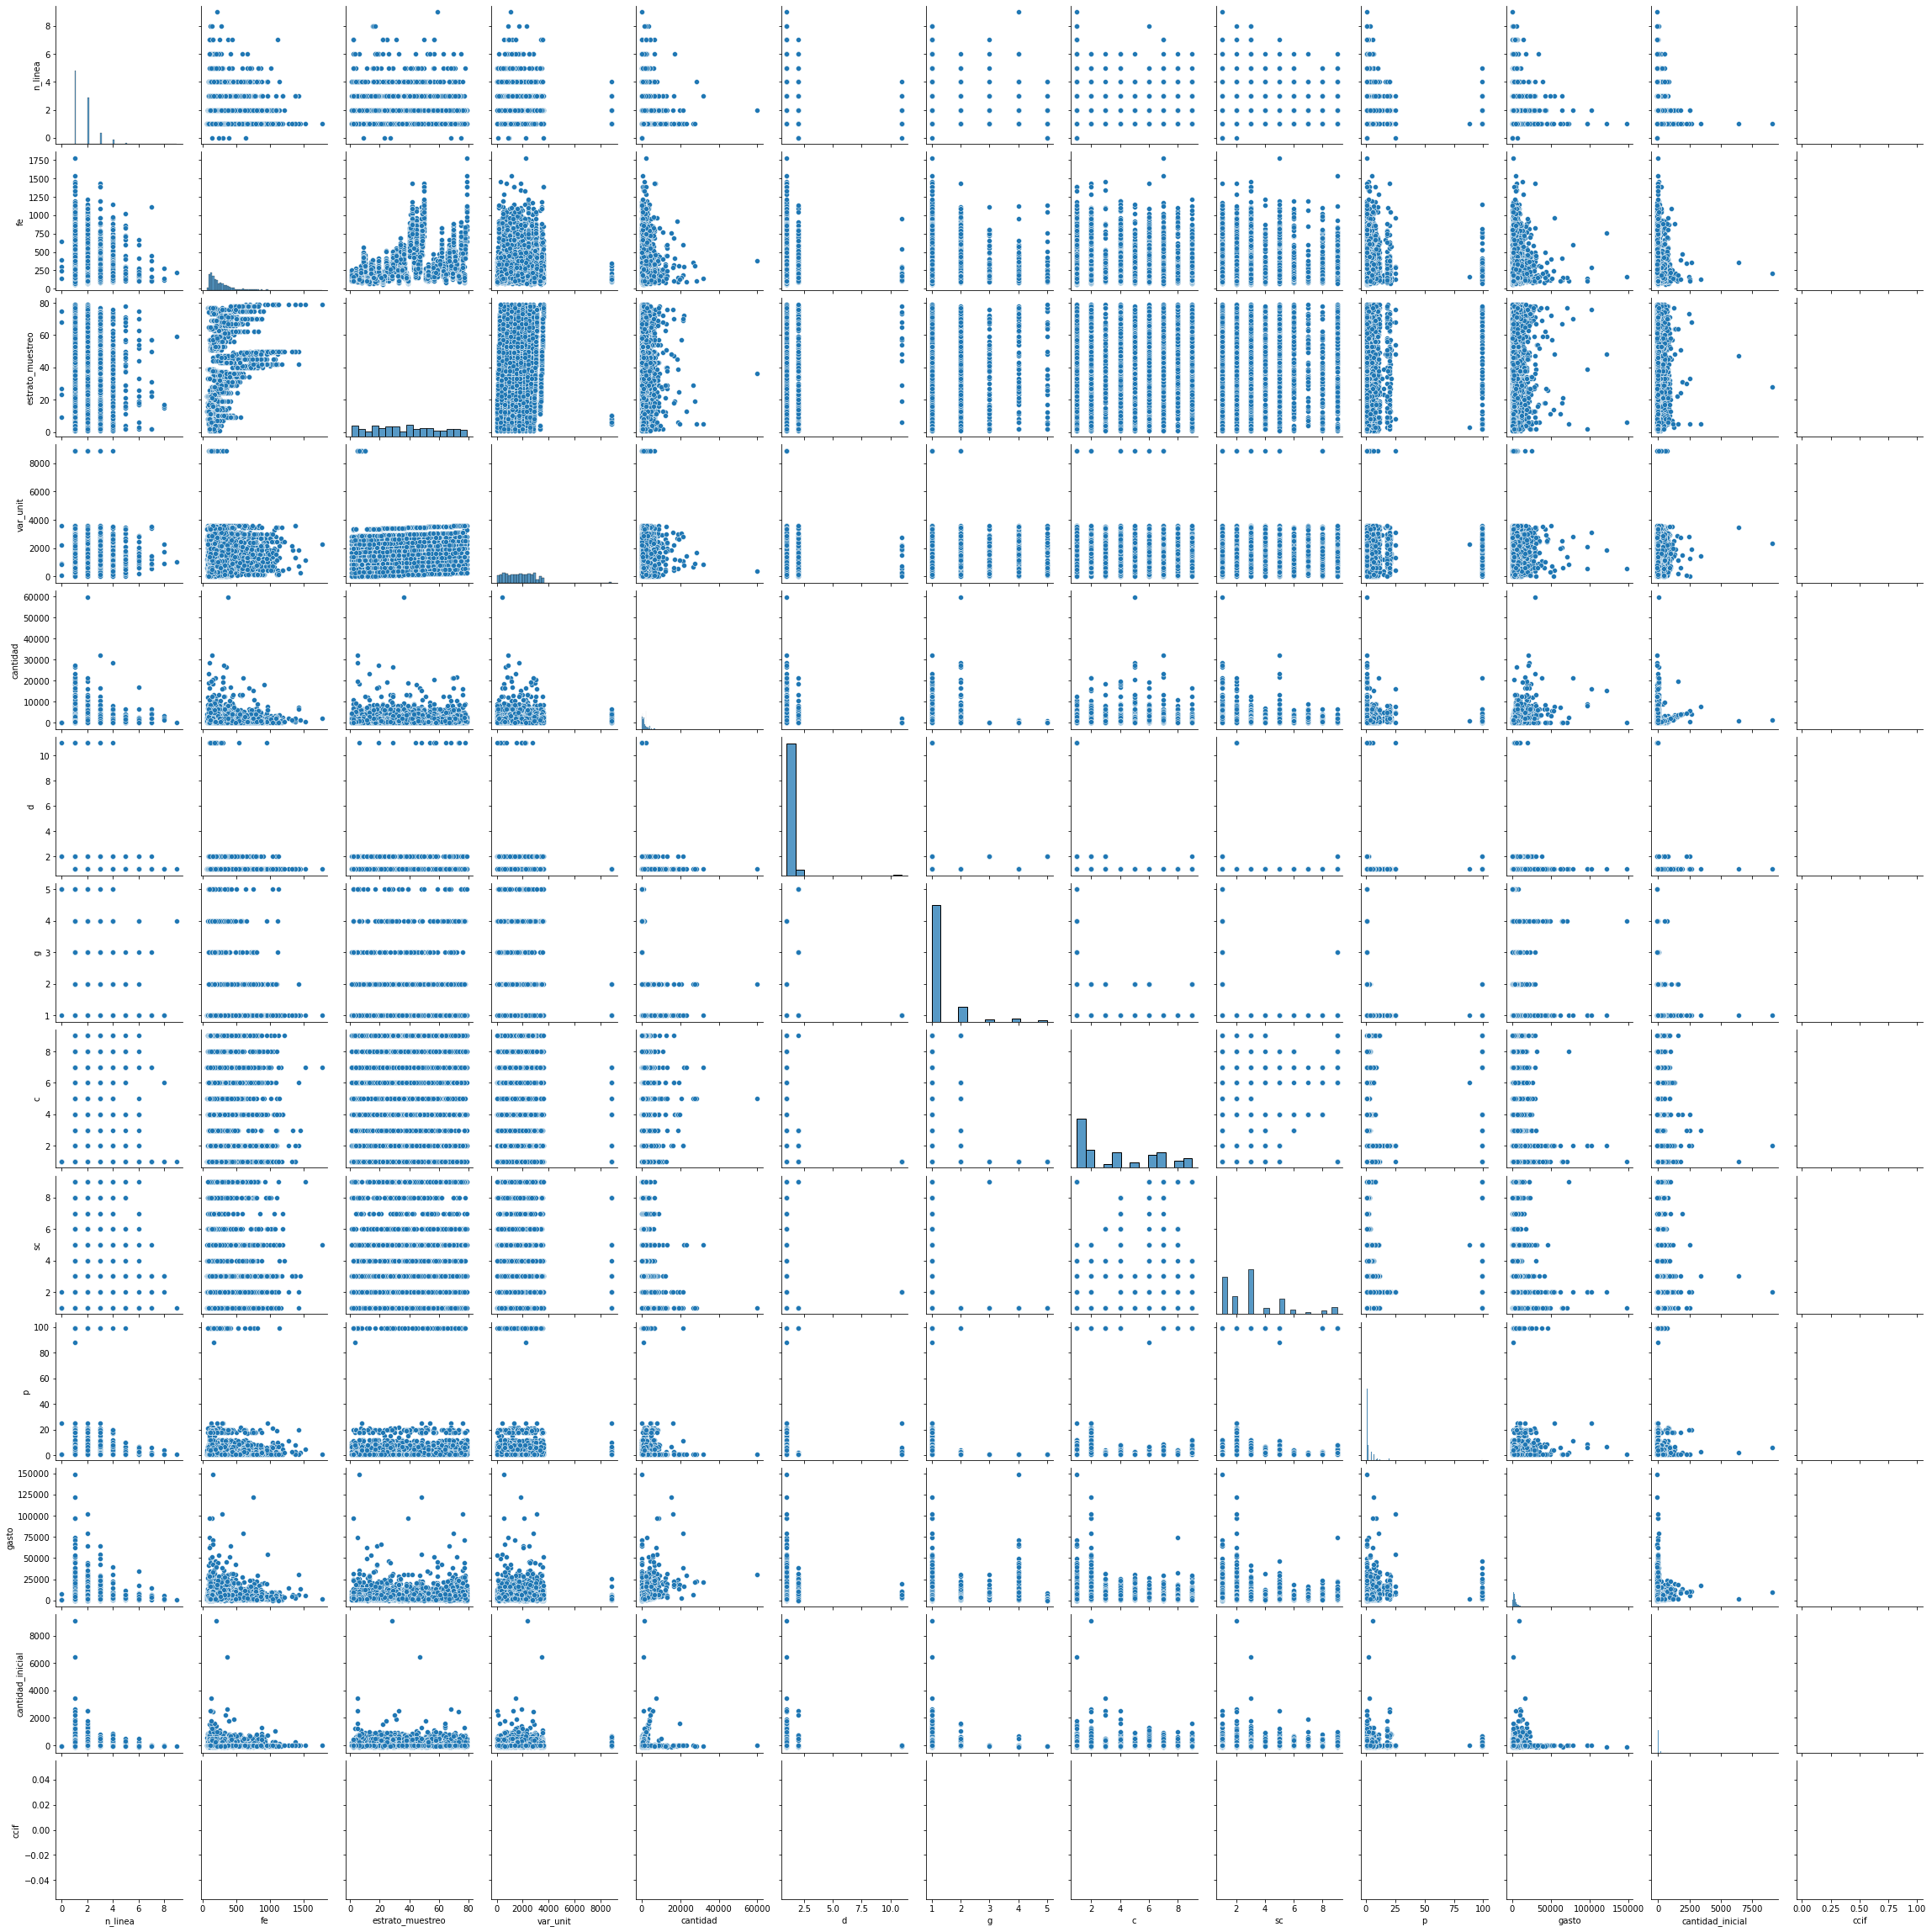

In [20]:
# Excluding spurious variables from our columns' dataset
cols = ["n_linea","fe","estrato_muestreo","var_unit",
        "cantidad","d","g","c","sc","p","gasto","cantidad_inicial","ccif"]
for col in cols:
    sampled_dataset[col] = sampled_dataset[col].astype(str).str.replace(',', '.')
    sampled_dataset[col] = pd.to_numeric(sampled_dataset[col], errors='coerce')
# Plot pairwise relationships in our dataset
pairwise_plot = sns.pairplot(sampled_dataset[cols])

La mayoría de los gráficos generados corresponde a nubes de puntos sin mayor interpretación posible. Otros tantos son gráficos de variables booleanas o con muy pocas alternativas como para detectar patrones claros.

Sin embargo, sí hay ciertas variables que al interactuar una con la otra se dividen en grupos o marcan tendencias. Ejemplos de ello son cantidad(Cantidad o número de bienes o servicios adquiridos) con el gasto(Gasto total del hogar por producto), fe(Factor de expansión a nivel vivienda) con la cantidad(Cantidad o número de bienes o servicios adquiridos) y sc(Subclase CCIF) con cantidad(Cantidad o número de bienes o servicios adquiridos).



<h3>6.2 . Matrix de Correlacion</h3>

Alternativamente, tambien podemos analizar la correlacion entre variables a traves de una matriz de correlacion y corroborar los resultados anteriores

In [21]:
# Calcular la matriz de correlación
correlation_matrix = sampled_dataset[cols].corr()

# Muestra la matriz de correlación
print("Matriz de Correlación:")
print(correlation_matrix)

Matriz de Correlación:
                   n_linea        fe  estrato_muestreo  var_unit  cantidad  \
n_linea           1.000000  0.024430         -0.047708 -0.018392  0.024106   
fe                0.024430  1.000000          0.361571 -0.022387 -0.001283   
estrato_muestreo -0.047708  0.361571          1.000000  0.013628 -0.032943   
var_unit         -0.018392 -0.022387          0.013628  1.000000 -0.009969   
cantidad          0.024106 -0.001283         -0.032943 -0.009969  1.000000   
d                 0.009494 -0.004567          0.041069 -0.033947 -0.047459   
g                 0.039718 -0.015895          0.010916  0.001049 -0.009268   
c                -0.005279 -0.016753          0.022753 -0.006094  0.058549   
sc               -0.004706  0.016157          0.032440 -0.013937 -0.181581   
p                -0.025044 -0.004149          0.023416 -0.007369 -0.011132   
gasto            -0.003309  0.026378          0.052465 -0.023099  0.364901   
cantidad_inicial -0.081506 -0.031934     

Analizando esta matriz de correlacion podemos obtener las variables más fuertemente asociadas, siendo estas la "cantidad" con el "gasto", el estrato con el "fe" y "g" con "sc"



<h3>6.3. Visualización en Tres Dimensiones</h3>

Evidentemente, el consumo será una variable que analizaremos. La edad no es tan atractiva, pues reconocemos dos grandes grupos, pero dentro de cada uno la edad es indistinta. La pobreza y la frecuencia sí serán variables atractivas y, si graficamos, podremos observar que efectivamente se crean grupos dentro de la muestra.



In [22]:
import nbformat
# Crear el gráfico 3D
fig = px.scatter_3d(sampled_dataset, x='cantidad', y='gasto', z='sc')

# Configurar el layout
fig.update_layout(scene=dict(xaxis=dict(range=[0, 100000])))
fig.update_layout(scene=dict(yaxis=dict(range=[0, 100000])))


Con los análisis anteriormente realizados, y si etiquetamos y revisamos exhaustivamente cada uno de los grupos, podríamos dar con una buena segmentación a priori.

No obstante, esto sólo nos servirá para identificar el número de segmentos hasta las tres dimensiones. Para segmentos cuyas variables críticas sean más de tres, tendremos que utilizar métodos estadísticos más complejos, como los que veremos a continuación.

<h2>7. Algoritmos de Segmentación Jerárquica</h2>

Se denomina segmentación jerárquica a aquella cuyos grupos comparten una raíz común en la muestra, separándose gradualmente y en forma interconectada en diferentes ramas. A continuación, importaremos las librerías específicas para realizar estas operaciones.

In [23]:
# Clustering Libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

<h3>7.1. Normalización, Depuración y Dendogramas</h3>

Normalmente, este ejercicio se inicia con la construcción de una gráfica denominada dendograma. En este caso, aplicaremos el método de mínima varianza de Ward para minimizar la varianza entre los clústers.

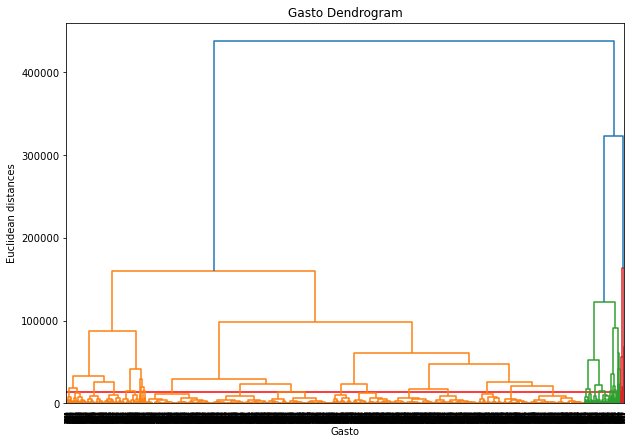

In [24]:
# Preparing our plot
plt.figure(figsize=(10, 7))
plt.title("Gasto Dendrogram")
plt.ylabel('Euclidean distances')
plt.xlabel('Gasto')

filtered_cols = ["cantidad", "sc", "gasto"]
selected_data = sampled_dataset[filtered_cols].copy(deep=True)

# Convertir todas las columnas a numéricas, ignorando errores
for col in filtered_cols:
    selected_data[col] = pd.to_numeric(selected_data[col], errors='coerce')

# Eliminar filas con valores NaN que resultaron de la conversión
selected_data.dropna(inplace=True)


clusters = sch.linkage(selected_data, method='ward', metric="euclidean")

# Aproximation to the number of clusters
plt.axhline(y = 14000, color = 'r', linestyle = '-')
# Creating and showing our dendogram
sch.dendrogram(Z=clusters)
plt.show()

Para determinar la cantidad de clústers, observaremos las distancias euclidianas, buscando el punto en que ellas son más largas, para luego trazar una línea horizontal aproximadamente por la mitad, en lo que se denomina "el método de Thorndike". La cantidad de verticales que atraviese es considerada una buena aproximación a la cantidad de clústers que tendremos en nuestra muestra [(Thorndike, 1953)](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.177.7605).

Dada la segmentación a priori, sabemos que contamos con al menos tres segmentos. Aplicando el método de Thorndike, tendríamos que concluir que en la muestra se observan dos segmentos. Sin embargo, y como mencionamos previamente, sabemos que en nuestra muestra hay variables cuya magnitud podría estar afectando nuestros análisis. Una forma de controlar por ello es normalizando los datos, cuestión que haremos a continuación.

In [25]:
dataset_normalized = sampled_dataset.copy(deep=True)

# Normalize each column of the dataset
for column in dataset_normalized.columns:
    # Check if column is numeric
    if dataset_normalized[column].dtype == 'object':
        continue

    # Normalize column
    dataset_normalized[column] = (dataset_normalized[column] - dataset_normalized[column].min()) / \
                                  (dataset_normalized[column].max() - dataset_normalized[column].min())

    # Transform NA values to zero
    dataset_normalized[column] = dataset_normalized[column].fillna(0)

    # Multiply by 100 to get a percentage and transform to int
    dataset_normalized[column] = (dataset_normalized[column] * 100).astype(int)

Tenga en cuenta, que para ejecutar el algoritmo que genera el dendograma, fue necesario transformar los valores normalizados de números decimales a enteros, multiplicando por 100 y forzando las columnas a tipo entero. Así, habiendo normalizado y transformado los datos, podemos analizar nuevamente el dendograma y evaluar si se corrigieron o no los problemas.

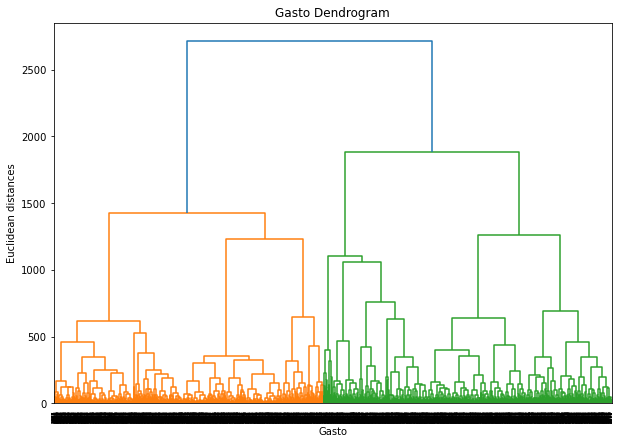

In [26]:
# Preparing our plot
plt.figure(figsize=(10, 7))
plt.title("Gasto Dendrogram")
plt.ylabel('Euclidean distances')
plt.xlabel('Gasto')

for col in dataset_normalized.columns:
    dataset_normalized[col] = dataset_normalized[col].astype(str).str.replace(',', '.')
# Selecting Annual Income and Spending Scores by index
excluded_cols = ["macrozona","folio_v","folio","n_linea","id_gasto",
                 "unidad_medida","glosa_ccif","ccif",
                 "glosa_establecimiento","cod_establecimiento","unidad_medida_inicial"]
filtered_cols = [col for col in dataset_normalized.columns
                 if col not in excluded_cols]
for col in filtered_cols:
    dataset_normalized[col] = pd.to_numeric(dataset_normalized[col], errors='coerce')

selected_data = dataset_normalized[filtered_cols].copy(deep=True)
clusters = sch.linkage(selected_data, method='ward', metric="euclidean")

# Creating and showing our dendogram
sch.dendrogram(Z=clusters)
plt.show()

<h3>7.2. Visualización de los Segmentos Creados</h3>

Existen dos algoritmos para clusterizar en forma jerárquica: los aglomerativos y los divisivos. En este ejercicio utilizaremos una estrategia aglomerativa, donde cada observación comienza en su propio grupo, y los pares de grupos son mezclados mientras uno sube en la jerarquía, en forma ascendente.

No obstante, y tanto para la determinación del número de grupos por medio del dendograma como para la clasificación de los individuos de nuestra muestra, se recomienda hacer uso de diferentes vínculos y métricas, y observar los resultados generados con una perspectiva de negocios [(Sampaio, 2022)](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/).

Text(0.5, 1.0, 'Gastos Data')

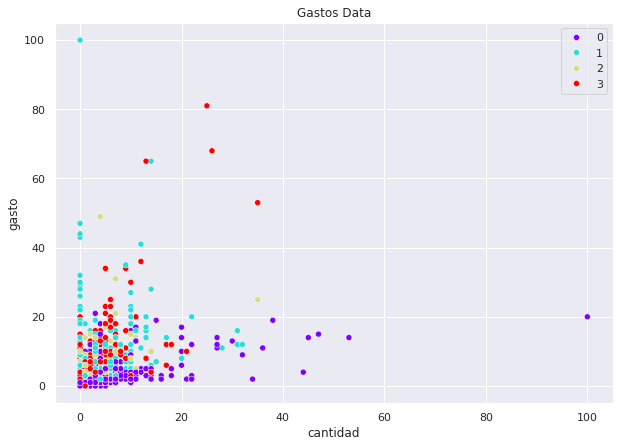

In [27]:
# Divisive Hierarchical Clustering using the euclidean distance and ward method
clustering_model = AgglomerativeClustering(n_clusters=4, metric='euclidean',
                                           linkage='ward')
clustering_model.fit(selected_data)

# Accessing vars of the clustering object
data_labels_v1 = clustering_model.labels_

# Visualization of our graph
sns.set(rc={'figure.figsize':(10, 7)})
sns.scatterplot(x='cantidad', y='gasto', data=selected_data,
                palette="rainbow", hue=data_labels_v1)\
                .set_title('Gastos Data')

<h3>7.3. Asignación de los Segmentos a la Muestra</h3>

Por último, agregamos una columna a nuestro dataset, cuyo contenido viene dado por las operaciones previas y permite asignar el grupo correcto a cada individuo..

In [28]:
# Copying our dataset to avoid future issues
dataset_segmented_v1 = dataset_normalized.copy(deep=True)

# Adding clusters and reverting values from numeric
segments = [f'cluster_{group + 1:02d}' for group in data_labels_v1]
dataset_segmented_v1.insert(loc=1, column='segment', value=segments)

dict_mappers = {'c': mapper_productos}

for col, mapper in dict_mappers.items():
  mapper_inv = {v: k for k, v in mapper.items()}
  dataset_segmented_v1[col] = dataset_segmented_v1[col].replace(mapper_inv)

dataset_segmented_v1.sort_values(by=['segment'], inplace=True)
dataset_segmented_v1

macrozona     segment folio_v    folio n_linea  fe  estrato_muestreo  \
793912        66  cluster_01      47   7138-1      11   6                67   
339943        33  cluster_01       9   1454-1      11  16                83   
698023        66  cluster_01      11   1774-1      22  17                10   
138044         0  cluster_01      39   5929-1      11   9                 3   
852651       100  cluster_01      70  10614-1      11   4                47   
...          ...         ...     ...      ...     ...  ..               ...   
516335        33  cluster_04      50   7500-1      22   5                64   
376488        33  cluster_04      17   2575-1      11   8                83   
154336         0  cluster_04      48   7208-1      22   6                71   
126402         0  cluster_04      35   5301-1      22  12                70   
185967         0  cluster_04      65   9733-1      22   6                70   

        var_unit    id_gasto  cantidad  ...   d   g    c  sc   p gasto  \
793912        27   7138-1-40         3  ...   0   0   62  25   1     1   
339943        15   1454-1-44         0  ...   0   0  100  37   0     2   
698023        13   1774-1-12         7  ...   0   0   75  12   6     2   
138044        22  5929-1-123         2  ...   0   0   75   0   0     1   
852651        38  10614-1-22         0  ...   0   0   87  25   3     1   
...          ...         ...       ...  ...  ..  ..  ...  ..  ..   ...   
516335        30   7500-1-31         3  ...   0   0    S  25   0     2   
376488        18    2575-1-9         1  ...   0   0    S  50   3     1   
154336        27   7208-1-76         3  ...   0   0   25  25   1     9   
126402        24   5301-1-49         0  ...  10  50    S   0   0     5   
185967        34   9733-1-34         3  ...   0   0   12  12  19     3   

        glosa_establecimiento  cod_establecimiento  cantidad_inicial  \
793912    ALMACÉN TRADICIONAL                    5                 1   
339943    ALMACÉN TRADICIONAL                    5                 3   
698023    ALMACÉN TRADICIONAL                    5                 1   
138044    ALMACÉN TRADICIONAL                    5                 0   
852651          SUPERMERCADOS                    0                 1   
...                       ...                  ...               ...   
516335   TIENDA ESPECIALIZADA                  100                 1   
376488          SUPERMERCADOS                    0                 5   
154336    ALMACÉN TRADICIONAL                    5                 0   
126402   TIENDA ESPECIALIZADA                  100                 0   
185967          SUPERMERCADOS                    0                10   

       unidad_medida_inicial  
793912                    KG  
339943                    GR  
698023                     K  
138044                   -77  
852651                  PACK  
...                      ...  
516335                    UN  
376488                    GR  
154336                   -77  
126402                   -77  
185967                   GRS  

[4000 rows x 23 columns]

<h2>8. Algoritmos de Segmentación No-Jerárquica</h2>

La segmentación no jerárquica implica la formación de grupos fusionando o dividiendo los clústers en forma no ramificada. Estas técnicas agrupan los datos para maximizar o minimizar algunos criterios de evaluación. K-Means es un algoritmo simple de *machine learning* de tipo no-supervisado que agrupa los datos en un número específico (k) de grupos.

In [29]:
# Clustering Libraries
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

<h3>8.1. Definición de la cantidad de Clústers</h3>

A continuación, filtraremos la mínima cantidad de variables con las que podemos correr el método del "codo" para definir la cantidad de segmentos a crear. Al igual que en el método jerárquico, seguramente necesitemos normalizar y omitir una serie de variables para que nuestro modelo sea parsimonioso.

De todas formas, es útil observar el proceso completo y ver cómo aplica en la práctica el concepto de que si entran datos de mala calidad a un modelo, los resultados de éste también serán de mala calidad. A este concepto se lo conoce por la sigla GIGO (Garbage In, Garbage Out) y se le atribuye a George Fuechsel (2004).

In [30]:
# Selecting Annual Income and Spending Scores by index
excluded_cols = ["macrozona","folio_v","folio","n_linea","id_gasto",
                 "unidad_medida","glosa_ccif","ccif",
                 "glosa_establecimiento","cod_establecimiento","unidad_medida_inicial"]
cols = ["n_linea","fe","estrato_muestreo","var_unit",
        "cantidad","d","g","c","sc","p","gasto","cantidad_inicial"]
for col in cols:
    dataset_normalized.loc[dataset_normalized[col].isna(),
                      col] = 0
base_data = dataset_normalized[cols].copy(deep=True)

Filtrados ya los datos, crearemos una función que calcula el algoritmo de k-medias en un loop entre 2 y 11 clústers, para así determinar el óptimo observando la suma del cuadrado de las distancias entre grupos (WCSS, por sus siglas en inglés):

\begin{align}
WCSS = \sum_{i\in n} (X_i-Y_i)^2
\end{align}

A continuación, haremos el ejercicio manualmente en un *for loop*:

In [31]:
def manual_elbow(selected_data):
  # Storing processed information and models
  df_kmeans = pd.DataFrame(columns=['clusters', 'wcss'])
  dict_kmeans = {}

  for i in range(1, 11):
    df_kmeans.loc[i, 'clusters'] = i

    # Definition of our k-means model and fitting our model
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000,
                    n_init=10, random_state=0)

    y_kmeans = kmeans.fit(selected_data)

    # Sum of squared distances to the closest cluster center
    df_kmeans.loc[i, 'wcss'] = kmeans.inertia_

    # Storing all variables for our specific
    dict_kmeans[i] = y_kmeans

  return {'df': df_kmeans, 'dict': dict_kmeans}

El número óptimo de clústers se define visualmente, observando el punto donde la pendiente de la curva se suaviza. El nombre del método viene dado imaginando que la curva fuera un brazo apoyado sobre una superficie, donde el punto de inflexión sería el codo.

In [32]:
base_data.tail(25)

n_linea  fe  estrato_muestreo  var_unit  cantidad    d   g    c  sc  \
109023      22   8                66        21         1    0   0    0  37   
934682      22   7                82        28         0    0   0   12  25   
546757      22  15                57         1         3    0   0   75  12   
570726      33  12                89        34         3    0   0   75   0   
62312       11   9                66        11         5    0   0   62   0   
712364      22  12                35        16         0  100   0    0  12   
716130      11   2                41        17         1    0   0    0  25   
775439      33  11                74        24         1    0   0   37  50   
209872      11   5                97        40         4    0   0   75  12   
794723      22   6                28        26        10    0  25   62   0   
372823      11   5                19        16         3    0   0   75  50   
613870      11  10                43        38         3    0   0   75  12   
433974      22  18                84        21         3    0   0   12  12   
956070      11   1                15        32         4    0  25    0   0   
868470      11   4                80         5         1    0   0    0  25   
820253      11   9                73        30         0    0   0  100  37   
895662      22   3                82        18         8    0   0   12  12   
468881      11  12                57        24         1    0   0    0  25   
450386      33  25                84        24         0    0   0   87  50   
666574      44  15                76         8        11    0   0   37  12   
957147      11   4                25        32         1    0   0   25  62   
98203       11   7                66        18         0    0   0   12  50   
47555       11  11                33         7         1    0   0   12  25   
91541       22   2                 1        15         0    0   0   50  12   
851528      22   2                12        37         2    0   0   75  12   

          p  gasto  cantidad_inicial  
109023    0      4                 4  
934682    1      2                 2  
546757    6      2                 1  
570726    0      3                 1  
62312     6      5                 1  
712364    0      4                 1  
716130    0      0                 1  
775439  100      6                 1  
209872    5      4                 1  
794723    0      2                 1  
372823    0      1                 1  
613870    6      1                 1  
433974   19      4                 1  
956070    0      2                 1  
868470    4      4                 1  
820253    1      0                 0  
895662   17     10                 1  
468881    0      0                 1  
450386    0      0                 1  
666574    0      4                 0  
957147    0      4                 5  
98203     4      1                 3  
47555     5      3                 0  
91541     0      1                 1  
851528    3      1                 1

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


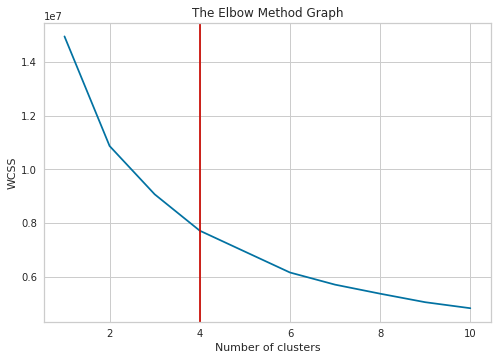

In [33]:
kmeans_base = manual_elbow(base_data)

# Plot the elbow graph
plt.plot(kmeans_base['df'].index.to_list(), kmeans_base['df']['wcss'].to_list())
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Visual proximation to the number of clusters
plt.axvline(x=4, color='r', linestyle='-')

# Plotting
plt.show()

Evidentemente, los datos son el problema y, en esencia, estamos en presencia de un problema similar al del punto 7.1. Conocida ya la solución, simplemente utilizaremos el DataFrame generado en ese punto, excluyendo también las mismas columnas.

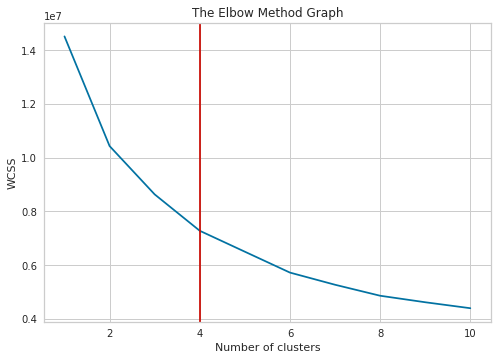

In [34]:
# Selecting Annual Income and Spending Scores by index
excluded_cols = ["macrozona","folio_v","folio","n_linea","id_gasto",
                 "unidad_medida","glosa_ccif","ccif",
                 "glosa_establecimiento","cod_establecimiento","unidad_medida_inicial"]

filtered_cols = [col for col in dataset_normalized.columns
                 if col not in excluded_cols]

selected_data = dataset_normalized[filtered_cols].copy(deep=True)
kmeans = manual_elbow(selected_data)

# Plot the elbow graph
plt.plot(kmeans['df'].index.to_list(), kmeans['df']['wcss'].to_list())
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Visual proximation to the number of clusters
plt.axvline(x=4, color='r', linestyle='-')

# Plotting
plt.show()

<h3>8.2. Cálculo Matemático del Óptimo</h3>

A continuación, se presenta una aproximación matemática al óptimo número de grupos a formarse en nuestro proceso de segmentación. Más información y detalle en el artículo de [Granville (2019)](https://www.datasciencecentral.com/how-to-automatically-determine-the-number-of-clusters-in-your-dat/).

In [36]:
# Copying our dataset to avoid future issues
df_optimal = kmeans_base ['df'].copy(deep=True)

for i in range(df_optimal.shape[0]):
  index = df_optimal.index[i]

  if i > 0: # Avoiding first value for which there's no delta
    delta01 = df_optimal.loc[index-1, 'wcss'] - df_optimal.loc[index, 'wcss']
    df_optimal.loc[index, 'Delta 1'] = delta01

  if i > 1: # Avoiding second value for which there's no delta
    delta02 = df_optimal.loc[index-1, 'Delta 1'] - df_optimal.loc[index, 'Delta 1']
    df_optimal.loc[index, 'Delta 2'] = delta02

    # Strenght calculations and filters
    strenght = df_optimal.loc[index-1, 'Delta 2'] - df_optimal.loc[index, 'Delta 1']
    df_optimal.loc[index, 'Strenght'] = next(s if s > 1 else None
                                             for s in [strenght])

df_optimal['Relative Strenght'] = df_optimal['Strenght'] / df_optimal.index
df_optimal.set_index(keys='clusters', drop=True, inplace=True)

# Optimal k by strenght values
max_strenght = df_optimal['Relative Strenght'].max()
optimal_k = df_optimal[df_optimal['Relative Strenght']==max_strenght].index[0]

# Display of calculation tables
display(df_optimal)

print(f'\nEl número óptimo es de {optimal_k} clústers.')

wcss       Delta 1       Delta 2       Strenght  \
clusters                                                               
1            14945507.831           NaN           NaN            NaN   
2         10864914.304121  4.080594e+06           NaN            NaN   
3          9066121.025046  1.798793e+06  2.281800e+06           None   
4          7711350.239159  1.354771e+06  4.440225e+05  927029.461916   
5          6932303.490658  7.790467e+05  5.757240e+05           None   
6          6154161.298549  7.781422e+05  9.045564e+02           None   
7          5701741.631629  4.524197e+05  3.257225e+05           None   
8          5365030.569268  3.367111e+05  1.157086e+05           None   
9          5047969.711656  3.170609e+05  1.965020e+04           None   
10           4824315.0292  2.236547e+05  9.340618e+04           None   

         Relative Strenght  
clusters                    
1                      NaN  
2                      NaN  
3                      NaN  
4            231757.365479  
5                      NaN  
6                      NaN  
7                      NaN  
8                      NaN  
9                      NaN  
10                     NaN


El número óptimo es de 4 clústers.



<h3>8.3. Visualización de los Segmentos Creados</h3>

Este paso no es realmente necesario, pero al igual que en el caso jerárquico, nos permite monitorear el rendimiento de los algoritmos aplicados en la clasificación realizada. Así, el objetivo es determinar visualmente si los clústers creados se condicen con la observación inicial y los resultados esperados.

Text(0.5, 1.0, 'Labeled Customer Data')

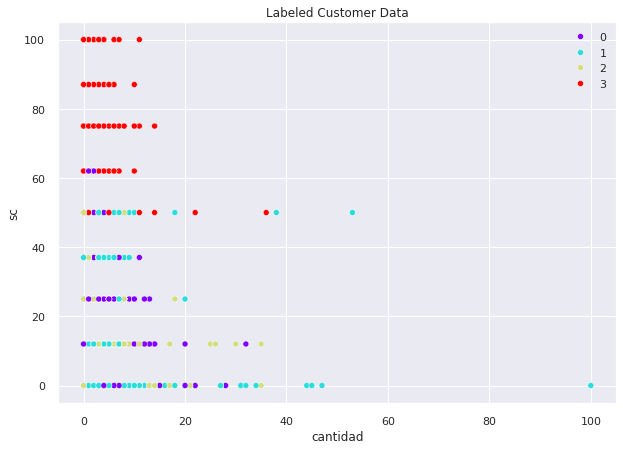

In [37]:
# Final clustering model
clustering_model = kmeans_base['dict'][4]

# Accessing vars of the clustering object
data_labels_v2 = clustering_model.labels_

# Visualization of our graph
sns.set(rc={'figure.figsize':(10, 7)})
sns.scatterplot(x='cantidad', y='sc', data=selected_data,
                palette="rainbow", hue=data_labels_v2)\
                .set_title('Labeled Customer Data')

Dada la cantidad de variables asignadas por segmento, la visualizacón en dos dimensiones no basta para discernir de manera evidente los clusters.

<h3>8.4. Asignación de los Segmentos a la Muestra</h3>

Por último, agregamos una columna a nuestro dataset, cuyo contenido viene dado por las operaciones previas y permite asignar el grupo correcto a cada individuo. Al contar con los DataFrames de uno y otro método, podremos determinar la efectividad de ambos modelos para reconocer cada segmento, además de analizar las diferencias entre ambos.

In [38]:
# Copying our dataset to avoid future issues
dataset_segmented_v2 = dataset_normalized.copy(deep=True)

# Adding clusters and reverting values from numeric
segments = [f'cluster_{group + 1:02d}' for group in data_labels_v2]
dataset_segmented_v2.insert(loc=1, column='segment', value=segments)

dict_mappers = {'c': mapper_productos}

for col, mapper in dict_mappers.items():
  mapper_inv = {v: k for k, v in mapper.items()}
  dataset_segmented_v2[col] = dataset_segmented_v2[col].replace(mapper_inv)

dataset_segmented_v2.sort_values(by=['segment'], inplace=True)
dataset_segmented_v2

macrozona     segment folio_v    folio n_linea  fe  estrato_muestreo  \
24358          0  cluster_01      77  11558-1      44  16                30   
944891       100  cluster_01      54   8106-1      11   0                48   
166236         0  cluster_01      56   8432-1      11   2                26   
150933         0  cluster_01      47   7166-1      22   5                 1   
900869       100  cluster_01      20   3096-1      11   1                14   
...          ...         ...     ...      ...     ...  ..               ...   
484400        33  cluster_04      42   6356-1      22  30                96   
326765        33  cluster_04       9   1402-1      22   3                19   
168665         0  cluster_04      56   8484-1      33  13                30   
955372       100  cluster_04      62   9378-1      11   3                48   
338748        33  cluster_04      97  14527-1      22  20                84   

        var_unit    id_gasto  cantidad  ...   d   g   c   sc  p gasto  \
24358          3  11558-1-37         4  ...   0   0   S   25  0     2   
944891        30    8106-1-9         4  ...   0   0   S   50  0     3   
166236        29   8432-1-68         1  ...   0   0   S   25  0     0   
150933        25   7166-1-43         0  ...   0   0  50   12  0     2   
900869        16   3096-1-46         0  ...   0   0  37   50  7     2   
...          ...         ...       ...  ...  ..  ..  ..  ... ..   ...   
484400        28   6356-1-53         0  ...  10  50   S  100  0     7   
326765        13   1402-1-89         0  ...   0   0  37   87  0     0   
168665        29  8484-1-107         0  ...   0   0  87  100  1     2   
955372        33   9378-1-15         5  ...   0   0  37   62  0     5   
338748        12  14527-1-12         1  ...   0   0  75  100  4     4   

        glosa_establecimiento  cod_establecimiento  cantidad_inicial  \
24358     ALMACÉN TRADICIONAL                    5                 0   
944891          SUPERMERCADOS                    0                 1   
166236    ALMACÉN TRADICIONAL                    5                 1   
150933    ALMACÉN TRADICIONAL                    5                 1   
900869    ALMACÉN TRADICIONAL                    5                 3   
...                       ...                  ...               ...   
484400   TIENDA ESPECIALIZADA                  100                 1   
326765    ALMACÉN TRADICIONAL                    5                 1   
168665          SUPERMERCADOS                    0                 0   
955372          SUPERMERCADOS                    0                 1   
338748          SUPERMERCADOS                    0                 1   

       unidad_medida_inicial  
24358                    -77  
944891                   PAQ  
166236              UNIDADES  
150933               PAQUETE  
900869                     G  
...                      ...  
484400                   -66  
326765                 3 UND  
168665                   -77  
955372                     U  
338748                    UN  

[4000 rows x 23 columns]

<h2>9. Definición de Perfiles y Buyer Personas</h2>

Generar perfiles implica generar una tipología o descripción de los consumidores que conformarán el o los mercados objetivos seleccionados. Se basan en las características compartidas por las personas de un segmento y, cuando se expresan como grupo, al que se le asigna un nombre genérico, o en la “persona” de un individuo tipo que podemos inventar para efectos del ejercicio en cuestión, dan lugar al concepto de buyer persona. Idealmente, se debiera incluir una descripción, motivaciones, y el rol que la marca podría llevar a cabo en la forma de satisfacer sus necesidades.

<h3>9.1. Comparación de los Resultados</h3>

A continuación, revisaremos si se encontraron diferencias en los segmentos definidos por ambos modelos. Para esto, utilizaremos una función nativa de Pandas, con la que veremos las filas que difieren entre las tablas.

In [39]:
# If needed, we adjust for the segments' number
mapper_segments = {'cluster_01': 'cluster_03', 'cluster_02': 'cluster_01',
                   'cluster_03': 'cluster_02'}

dataset_segmented_v2['segment'] = dataset_segmented_v2['segment'].replace(
    mapper_segments)

dataset_segmented_v2.sort_values(by=['segment'], inplace=True)

df_diff = dataset_segmented_v1.compare(dataset_segmented_v2)
print(f'Se encontraron {df_diff.shape[0]} filas distintas entre las tablas...')

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

De encontrarse diferencias entre los modelos, y si son relativamente pocas, se recomienda filtrarlas y analizar luego de revisar la estadística descriptiva de cada segmento a cuál debieran pertenecer. Dado que en este caso ambas tablas son iguales, a continuación se definirá el dataset final tomando la primera tabla como referencia:

In [40]:
# Copying our dataset to avoid future issues
dataset_segmented = dataset_normalized.copy(deep=True)

# Adding clusters and reverting values from numeric
segments = [f'cluster_{group + 1:02d}' for group in data_labels_v2]
dataset_segmented.insert(loc=1, column='segment', value=segments)

<h3>9.2. Estadística Descriptiva por Grupo</h3>

El siguiente bloque de código tiene por objetivo imprimir los promedio de cada columna para los distintos segmentos. Así, tras ejecutarlo veremos impresa esta información para cada grupo, pudiéndose construir fácilmente los perfiles a partir de esta información.

In [55]:
# Selecting columns to describe
excluded_cols = ['Segmento',"macrozona","folio_v","folio","n_linea","id_gasto",
                 "unidad_medida","glosa_ccif","ccif",
                 "glosa_establecimiento","cod_establecimiento","unidad_medida_inicial"]

filtered_cols = [col for col in dataset_segmented.columns
                 if col not in excluded_cols]

df_clustered = dataset_segmented[filtered_cols].copy(deep=True)

# Setting main variables to iterate over
dict_clusters = {}
list_dicts = []

for group in df_clustered['segment'].unique():
  # Filtering values for descriptive analysis to be done
  df_group = df_clustered[df_clustered['segment']==group].copy(deep=True)

  # Filling our cluster dictionary with the descriptive analysis
  dict_clusters[group] = df_group.describe(percentiles=[])

for cluster, values in dict_clusters.items():
  local_dict = {}

  # Future cluster index aggregation and addition of dict to list
  local_dict['cluster'] = cluster

  # Adding the number of individuals of each cluster
  group = int(re.search('(\d)+', cluster).group(1))
  size = df_clustered[df_clustered['segment']==group].shape[0]
  local_dict['size'] = size

  # Adding all the other values
  local_dict = {**local_dict, **dict(values.loc['mean', :])}

  for col in excluded_cols:
        if col in dataset_segmented.columns:
            mode_value = dataset_segmented[dataset_segmented['segment']==cluster][col].mode().iloc[0]
            local_dict[col] = mode_value
  
  list_dicts.append(local_dict)

df_archetypes = pd.DataFrame(list_dicts)
df_archetypes.set_index(keys='cluster', drop=True, inplace=True)
df_archetypes.sort_index(ascending=True, inplace=True)
df_archetypes.index.name = None

pd.set_option('display.float_format', lambda x: '%.1f' % x)
display(df_archetypes)

IndexError: single positional indexer is out-of-bounds

Es mucho lo que podemos determinar a partir de una información tan básica como las medias para cada variable observada de los grupos. A continuación, analizaremos variable por variable los resultados:

*   Size: 
*   fe (Factor de expansión a nivel vivienda): 
*   estrato_muestreo (estrato_muestreo): 
*   var_unit (Conglomerado de varianza): 
*   cantidad (Cantidad o número de bienes o servicios adquiridos): 
*   d (División CCIF): 
*   g (Grupo CCIF): 
*   c (Clase CCIF): 
*   sc(Subclase CCIF):  
*   p(Producto CCIF):
*   g (Gasto total del hogar por producto):
*   cantidad_inicial(Cantidad o número de bienes o servicios adquiridos reportada):

Con estas nociones claras, podemos aventurar algunas hipótesis que validaremos contra los datos nominales y nuestro conocimiento circunstancial.

<h3>9.3. Propuesta de Perfiles</h3>

Los perfiles que se presentan a continuación nacen de un trabajo iterativo y acabado de estudio de las variables nominales que, junto con el conocimiento circunstancial y de mercados, permite al equipo de Inteligencia de Mercados de Bimarc proponer una explicación a cada segmento.

1.   Se identificaron cuatro clústeres de consumidores. El primero, conocido como "Joven Innovador", se caracteriza por 	Alta disposición a pagar por alternativas saludables y sostenibles, a	Alta actividad en redes sociales y compras online. Prefieren probar nuevos productos alimentarios y son 	influenciados por promociones y descuentos.
2.   El segundo clúster, llamado "Comprador Tradicional", posee alta lealtad a marcas conocidas y productos locales y menos confianza en compras digitales. Prefieren tiendas físicas y productos sostenibles y tambien poseen una valoración de la calidad y origen de los productos
3.   El tercer segmento, "Generación X", busca un equilibrio entre innovación y tradición, además de tener una alta preocupación por la sostenibilidad. Prefieren productos saludables y sostenibles y tienen una moderada disposición a pagar por nuevos productos
4.  El cuarto segmento, "El Comprador Económico", perteneciendo a todos los grupos etarios, prefieren los canales de compra que ofrezcan mejores ofertas y guían sus compras por promociones y descuentos. Buscan maximizar el valor de sus compras. y estan fuertemente Influenciados por el precio y la disponibilidad de promociones.

<h3>9.4. Creación de Buyer Personas (POR HACER)</h3>

A continuación se presenta una propuesta de buyer personas para cada uno de los segmentos identificados. Tome en consideración que para ello fue necesario investigar las características de los perfiles propuestos, cuestión de la que usted debiera dar cuenta en su informe.

---
**Buyer Persona para "El Joven Innovador"**

Nombre: Ana<br>
Edad: 25-35 años.<br>
Nivel educativo: Ingeniera Comercial.<br>

Características clave:
*   Apasionada por la comida y la gastronomía.
*   Le encanta probar nuevos sabores y explorar diferentes cocinas.
*   Activa en redes sociales y blogs culinarios donde comparte sus experiencias.
*   Tiene un ingreso estable y dispone de un presupuesto moderado para comer fuera.

Necesidades y deseos:
*   Busca restaurantes de alta calidad y experiencias culinarias únicas.
*   Siempre está en busca de ingredientes gourmet para cocinar en casa.
*   Valora la calidad y autenticidad de los alimentos.

---
**Buyer Persona para "Chefs"**

Nombre: Carlos<br>
Edad: 35-50 años.<br>
Nivel educativo: Graduado en Escuela de Chef Profesional.<br>

Características clave:
*   Chef profesional o dueño de restaurante.
*   Experimentado en la cocina y apasionado por la gastronomía.
*   Conocedor de ingredientes y técnicas culinarias avanzadas.
*   Tiene un ingreso moderado y busca calidad sobre cantidad.

Necesidades y deseos:
*   Busca proveedores de alimentos de alta gama para su restaurante.
*   Siempre está en búsqueda de ingredientes frescos y de calidad.
*   Valora la innovación en la cocina y está dispuesto a invertir en ingredientes excepcionales.

---
**Buyer Persona para "Asesoras del Hogar"**

Nombre: María<br>
Edad: 45-55 años.<br>
Nivel educativo: Educación secundaria.<br>

Características clave:

*   Trabaja como asesora del hogar en una zona residencial de alto poder adquisitivo.
*   Responsable de la gestión de la cocina y compras de reposición del el hogar donde trabaja.
*   Tiene un ingreso moderado y sus compras personales no las realiza en los locales de Bimarc Food Market.

Necesidades y deseos:

*   Busca eficiencia en las compras y productos de calidad para el hogar.
*   Valora la conveniencia y la durabilidad de los productos.
*   Su enfoque principal es mantener el hogar bien abastecido y satisfacer las necesidades culinarias de los residentes.

---

Estos buyer personas permiten a los equipos de marketing un trabajo más natural, al conectar los segmentos con un perfil y luego una idea con la que el interlocutor del informe se puede familiarizar de forma más humana y comprensible.